In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_excel('data.xlsx', index_col=0)
data.head(3)

,target,c1,c2,c3,c4,c5,c6,c7,c8,f1,f2,f3
loan_id,,,,,,,,,,,,
1,0,NaN,100.987693,0.244307,NaN,292.990245,-7.608697,29.799024,0.000254,cat3,cat2,cat1
2,1,-3.491385,69.729741,1.203940,NaN,300.505830,-3.341621,30.550583,0.000343,cat4,cat2,cat1
3,1,-13.319012,171.782722,0.643540,NaN,324.569894,-6.020134,32.956989,0.000113,NaN,NaN,cat2


In [3]:
data.describe()

,target,c1,c2,c3,c4,c5,c6,c7,c8
count,1000.000000,895.000000,898.000000,898.000000,8.980000e+02,896.000000,891.000000,904.000000,891.000000
mean,0.505000,-19.121633,104.545624,-2.157325,7.191213e-01,312.715550,-1.107039,31.696265,0.009874
std,0.500225,6.529655,28.405828,64.948341,1.818080e+01,93.347974,4.190027,9.425144,0.030112
min,0.000000,-41.035358,0.000000,-1930.139580,1.991749e-09,-5.000000,-15.241649,0.000000,0.000003
25%,0.000000,-23.506621,85.227066,-0.574418,7.641420e-05,253.703807,-3.886878,25.426370,0.000930
50%,1.000000,-18.945191,103.142654,0.322452,8.525977e-04,309.875590,-1.078512,31.633251,0.002697
75%,1.000000,-14.771743,123.320364,0.729773,1.227027e-02,374.749219,1.788421,37.974922,0.008418
max,1.000000,0.000000,188.117528,85.586040,5.440642e+02,666.955488,13.851844,67.195549,0.608675


### Let's look at the amount on nan values in data



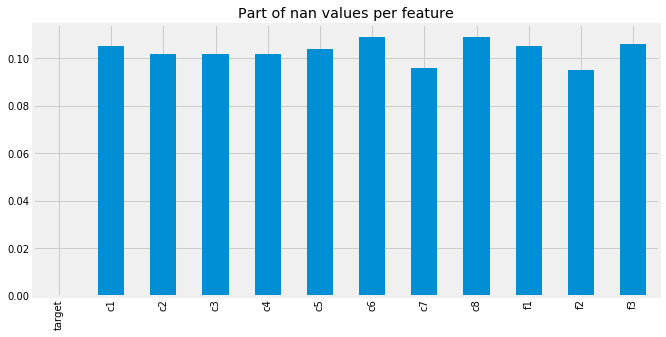

In [4]:
plt.figure(figsize=(10,5))
data.isnull().mean().plot('bar');
plt.title('Part of nan values per feature');

### Let's see how balanced are our classes

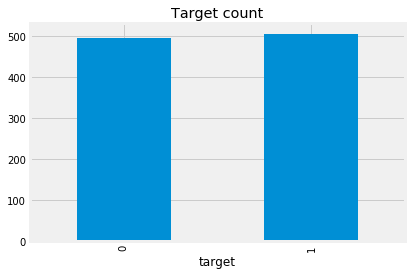

In [5]:
data.groupby('target')['target'].count().plot('bar');
plt.title('Target count');

### As we can see 70% of data contains at least on nan in features

In [6]:
data.isnull().any(axis=1).mean()

0.7

### Amount are pretty the same per class

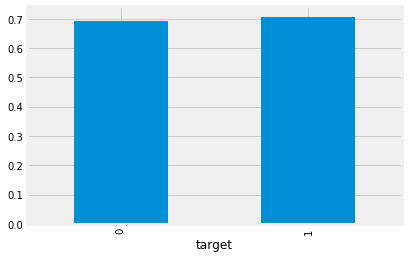

In [7]:
data.groupby('target').apply(lambda x: x.isnull().any(axis=1).mean()).plot('bar');

## Because of this big amount of nan in data it would make sense to leave nans in each column as additional feature



### Let's take a look at categorical features and dependencies with target 

In [8]:
for col_name, col in data.filter(like='f').fillna('nan').items():
  display(
  pd.crosstab(col, data['target'], normalize='index').style.background_gradient(cmap='viridis'))

target,0,1
f1,,
cat1,0.572464,0.427536
cat2,0.477124,0.522876
cat3,0.464088,0.535912
cat4,0.511111,0.488889
nan,0.457143,0.542857


target,0,1
f2,,
cat1,0.283828,0.716172
cat2,0.582781,0.417219
cat3,0.633333,0.366667
nan,0.452632,0.547368


target,0,1
f3,,
cat1,0.575221,0.424779
cat2,0.558036,0.441964
cat3,0.53125,0.46875
cat4,0.327273,0.672727
nan,0.462264,0.537736


### We can create new features from nan values

### Let's see how target value depends on nan in real-valued features


In [9]:
for col_name, col in data.filter(like='c').isnull().items():
  display(
  pd.crosstab(col, data['target'], normalize='index').style.background_gradient(cmap='viridis'))

target,0,1
c1,,
False,0.498324,0.501676
True,0.466667,0.533333


target,0,1
c2,,
False,0.485523,0.514477
True,0.578431,0.421569


target,0,1
c3,,
False,0.491091,0.508909
True,0.529412,0.470588


target,0,1
c4,,
False,0.496659,0.503341
True,0.480392,0.519608


target,0,1
c5,,
False,0.497768,0.502232
True,0.471154,0.528846


target,0,1
c6,,
False,0.496072,0.503928
True,0.486239,0.513761


target,0,1
c7,,
False,0.484513,0.515487
True,0.59375,0.40625


target,0,1
c8,,
False,0.498316,0.501684
True,0.46789,0.53211


### As we can see info about nan in such columns as c7, c2, c8, c1 colud help estimator to predict target

### Let's buil corr map of real-valued features

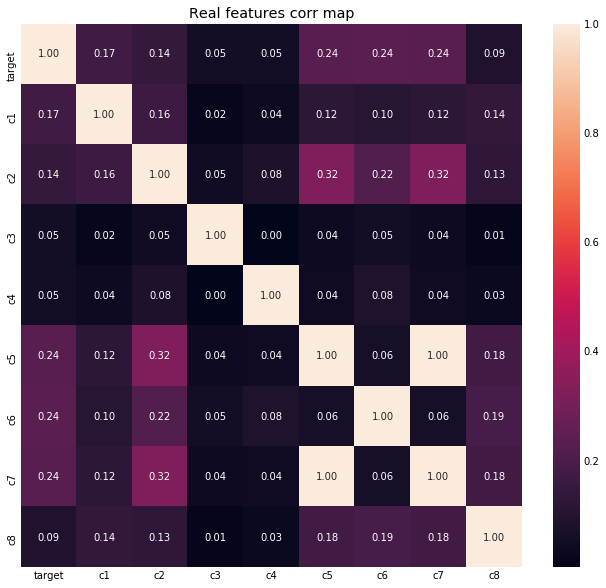

In [10]:
corr = data[['target']].join(data.filter(like='c')).dropna().corr().abs()

# plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Real features corr map')
plt.show()

# Datset creation


In [0]:
categorical_columns = ['f1','f2', 'f3']
real_columns = ['c1','c2',	'c3',	'c4',	'c5',	'c6',	'c7', 'c8']

In [12]:
def get_features(data_):
  data = data_.drop(['target'], axis=1)
  
  # add isnull features
  is_null_cols=['c7', 'c2', 'c1', 'c8']
  data = data.join(data[is_null_cols].isnull(), rsuffix='_isnull')
  
  #fillna
  data.loc[:, real_columns] = data[real_columns].fillna(data[real_columns].mean())

  #code categorical features
  for col in categorical_columns:
    data[col] = data[col].astype("category").cat.codes

  return data

features = get_features(data)
target = data['target']
features.head(3)

,c1,c2,c3,c4,c5,c6,c7,c8,f1,f2,f3,c7_isnull,c2_isnull,c1_isnull,c8_isnull
loan_id,,,,,,,,,,,,,,,
1,-19.121633,100.987693,0.244307,0.719121,292.990245,-7.608697,29.799024,0.000254,2,1,0,False,False,True,False
2,-3.491385,69.729741,1.203940,0.719121,300.505830,-3.341621,30.550583,0.000343,3,1,0,False,False,False,False
3,-13.319012,171.782722,0.643540,0.719121,324.569894,-6.020134,32.956989,0.000113,-1,-1,1,False,False,False,False


### Let's build a test dataset for us


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
      features, target, test_size=0.2, random_state=44)

### As we can see there are only 1000 sample so let's start with simple models


In [0]:
rfc=RandomForestClassifier(random_state=42)

In [0]:
param_grid = { 
    'n_estimators': [100, 150, 200,250, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [ 5, 7, 10, 15, 20, 25, 30, 40],
    'criterion' :['gini', 'entropy']
}

### Finding best params on training set

### We can use accuracy as our score because the classes are balanced

In [16]:
CV_rfc = GridSearchCV(scoring='accuracy',
                      estimator=rfc, 
                      param_grid=param_grid, 
                      cv=5, n_jobs=-1,
                      verbose=1)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cr

In [17]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 300}

### Best score on train

In [18]:
CV_rfc.best_score_

0.80375

### Predicting on test dataset 

In [25]:
rfc1 = CV_rfc.best_estimator_
rfc1.fit(X_train, y_train)
y_pred=rfc1.predict(X_test)
print("Accuracy for Random Forest on CV data: ", accuracy_score(y_test,y_pred))

Accuracy for Random Forest on CV data:  0.79


### Let's now try another model architecture

## Gradient Boosting Classifier

In [42]:
from sklearn.ensemble import GradientBoostingClassifier


clf=GradientBoostingClassifier(random_state=42)

param_grid = {'learning_rate':[0.05, 0.07,0.1,0.15, 0.2], 
              'min_samples_split':[5,10,15,20], 
              'max_depth':[4,5,7,10,15],
             'n_estimators':[100, 150, 200]}

gs = GridSearchCV(scoring='accuracy',
                      estimator=clf, 
                      param_grid=param_grid, 
                      cv=5, n_jobs=-1,
                      verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  8.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  presort='auto',
  

In [43]:
gs.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'min_samples_split': 5,
 'n_estimators': 150}

### Result is better then with random forest

In [44]:
gs.best_score_

0.835

## Predicting on test

In [46]:
clf1 = gs.best_estimator_
clf1.fit(X_train, y_train)
y_pred=clf1.predict(X_test)
print("Accuracy for Gradient Boosting on CV data: ",accuracy_score(y_test,y_pred))

Accuracy for Gradient Boosting on CV data:  0.835


### We got pretty good results on test comparing to random forest.


### It would be very interesting to work with neural network and bigger dataset, also info about features could be helpful.

### For model deploying, I'd use a classic approach. A simple server containing a trained model and code for feature preprocessing with API using Docker. Prediction could be retrieved using simple GET request to API with parameters of the sample.